<a href="https://colab.research.google.com/github/Emma-Ok/Phishing-Detection-ML/blob/alc4dev/ModelsWithAllSamples/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Random Forest para Detección de Phishing
import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler, RandomSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    StratifiedKFold,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    matthews_corrcoef
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# CARGA Y PREPARACIÓN DE DATOS

# Carga directa desde GitHub
url = "https://raw.githubusercontent.com/Emma-Ok/Phishing-Detection-ML/main/Phishing_Legitimate_full.csv"
df = pd.read_csv(url)
df = df.drop(columns=['id'])

# Separar X e y
X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

print(f"Forma del dataset: {X.shape}")
print(f"Distribución de clases: {Counter(y)}")

# DIVISIÓN DEL DATASET (70-15-15)

print("\n🔄 Dividiendo dataset...")

# Primera división: 70% entrenamiento, 30% temporal
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Segunda división: 15% validación, 15% prueba
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Validación: {X_val.shape[0]} muestras") 
print(f"Prueba: {X_test.shape[0]} muestras")


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [34]:
def get_rf_objective(X, y, cv=5, scoring='f1'):
    """
    Retorna una función objetivo para optimizar hiperparámetros de RandomForest con Optuna.
    
    Parámetros:
    - X: Features del dataset.
    - y: Etiquetas del dataset.
    - cv: Número de particiones para validación cruzada.
    - scoring: Métrica a optimizar ('accuracy', 'roc_auc', etc.).

    Retorna:
    - Función objetivo compatible con optuna.
    """
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42,
            'n_jobs': -1
        }

        clf = RandomForestClassifier(**params)
        scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)

        return scores.mean()

    return objective


In [51]:
def evaluate_rf_model_optuna(X_train, y_train, n_trials=50, timeout=None):
    """
    Optimiza un Random Forest usando Optuna y devuelve el mejor modelo y sus hiperparámetros.

    Args:
        X_train (np.array): Datos de entrenamiento (features)
        y_train (np.array): Etiquetas de entrenamiento
        n_trials (int): Número de pruebas de Optuna
        timeout (int): Tiempo máximo en segundos para la optimización

    Returns:
        best_model (RandomForestClassifier): Modelo entrenado con los mejores hiperparámetros
        best_params (dict): Diccionario de mejores hiperparámetros
    """
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    objective = get_rf_objective(X=X_train, y=y_train, cv=cv_strategy)

    study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42, n_startup_trials=10, multivariate=True, group=True))
    study.optimize(objective, n_trials=n_trials, timeout=timeout, show_progress_bar=True)

    best_params = study.best_params
    best_score = study.best_value

    print(f"\n✅ Mejores hiperparámetros encontrados:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    print(f"\n📈 Mejor F1-Score en validación cruzada: {best_score:.4f}")

    return best_params

In [10]:
# Función para calcular las métricas de evaluación
def calculate_metrics(y_true, y_pred, y_proba, set_name):
    
    print(f"\n=== MÉTRICAS - {set_name.upper()} ===")
    
    # Métricas principales
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    
    # Métricas complementarias
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    print(f"Accuracy (Exactitud):     {accuracy:.4f}")
    print(f"Precision (Precisión):    {precision:.4f}")
    print(f"Recall (Sensibilidad):    {recall:.4f}")
    print(f"F1-Score:                 {f1:.4f}")
    print(f"AUC-ROC:                  {auc_roc:.4f}")
    print(f"Specificity (Especific.): {specificity:.4f}")
    print(f"MCC:                      {mcc:.4f}")
    
    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall,
        'f1_score': f1, 'auc_roc': auc_roc, 'specificity': specificity,
        'mcc': mcc
    }

In [52]:
# MODELO FINAL Y EVALUACIÓN
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_val_scaled=scaler.transform(X_val)
X_test_scaled=scaler.transform(X_test)

#Modelo con mejores hiperparametros
best_params = evaluate_rf_model_optuna(X_train=X_train_scaled, y_train=y_train, n_trials=50)

# Entrena modelo final
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train_scaled, y_train)
# Predicciones en conjunto de validación
y_val_pred = best_rf.predict(X_val_scaled)
y_val_proba = best_rf.predict_proba(X_val_scaled)[:, 1]

# Predicciones en conjunto de prueba
y_test_pred = best_rf.predict(X_test_scaled)
y_test_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

#  CÁLCULO DE MÉTRICAS PRINCIPALES

# Evaluación en validación y prueba
val_metrics = calculate_metrics(y_val, y_val_pred, y_val_proba, "Validación")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_proba, "Prueba")

[I 2025-06-18 17:11:37,317] A new study created in memory with name: no-name-af2f30ab-0c81-4047-a44b-b07ff79b3af5


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-18 17:11:39,234] Trial 0 finished with value: 0.9700269320399144 and parameters: {'n_estimators': 144, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9700269320399144.
[I 2025-06-18 17:11:41,531] Trial 1 finished with value: 0.9675479909096708 and parameters: {'n_estimators': 200, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.9700269320399144.
[I 2025-06-18 17:11:43,175] Trial 2 finished with value: 0.9754282366401259 and parameters: {'n_estimators': 126, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.9754282366401259.
[I 2025-06-18 17:11:45,426] Trial 3 finished with value: 0.9681440236869099 and parameters: {'n_estimators': 164, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max

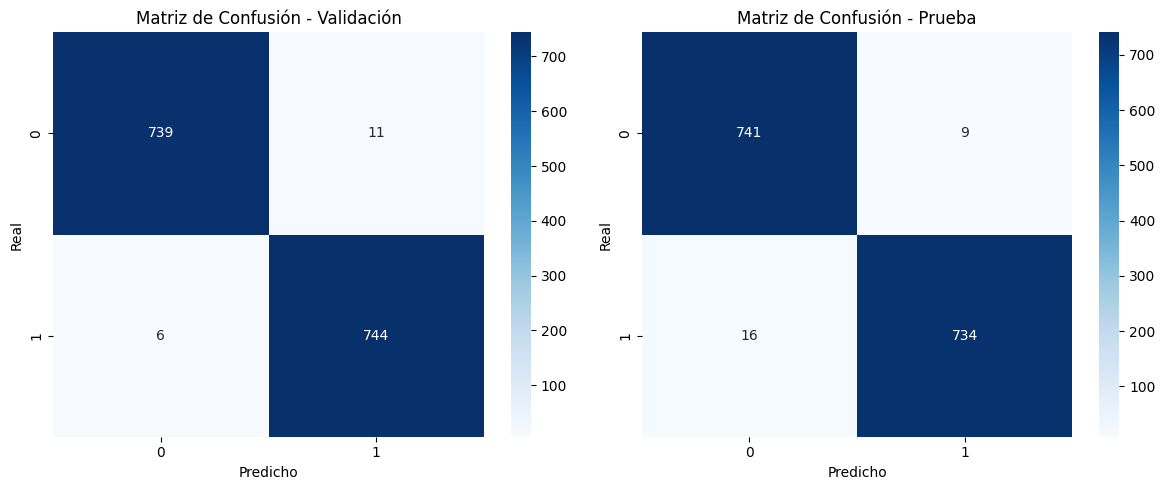

In [53]:
# MATRIZ DE CONFUSIÓN

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusión - Validación
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Validación')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

# Matriz de confusión - Prueba
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Prueba')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

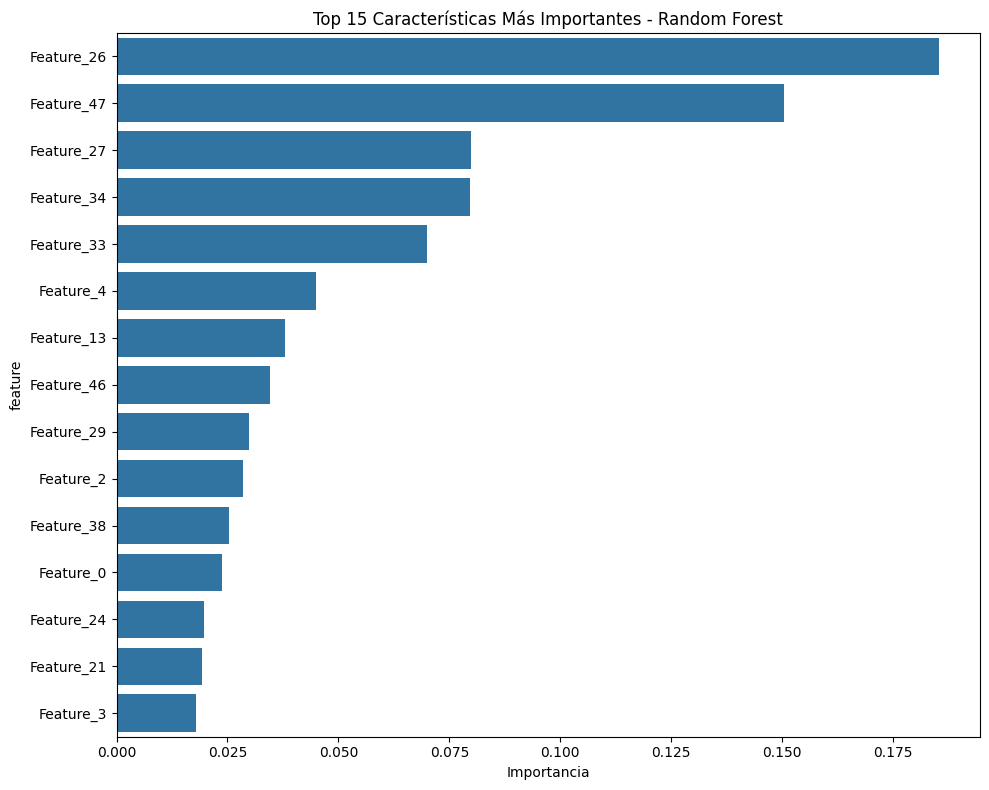

Top 10 Características:
 1. Feature_26: 0.1853
 2. Feature_47: 0.1504
 3. Feature_27: 0.0798
 4. Feature_34: 0.0797
 5. Feature_33: 0.0699
 6. Feature_4: 0.0451
 7. Feature_13: 0.0381
 8. Feature_46: 0.0345
 9. Feature_29: 0.0299
10. Feature_2: 0.0285


In [54]:
# IMPORTANCIA DE CARACTERÍSTICAS

# Obtener importancias
feature_importance = best_rf.feature_importances_
feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Visualizar top 15 características más importantes
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Características Más Importantes - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

print("Top 10 Características:")
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")
